In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist            # MNIST handwritten digits data!
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / 255
X_test = X_test / 255

11490434/11490434 [==============================] - 0s 0us/step


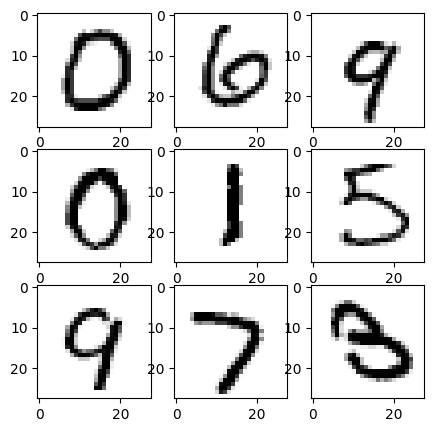

In [3]:
n_rows = 3
n_cols = 3
n_shift = 10
f, a = plt.subplots(n_rows, n_cols, figsize=(5, 5))
for i in range(n_rows):
    for j in range(n_cols):
        single_image = X_test[n_shift+i*n_cols+j].reshape(28,28)
        a[i,j].imshow(1.0-single_image, cmap='gist_gray')      # In Grayscale.
plt.show()

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses


In [5]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = X_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


In [6]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [7]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/10
1875/1875 [==============================] - 9s 3ms/step - loss: 0.0241 - val_loss: 0.0094
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.004

In [8]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


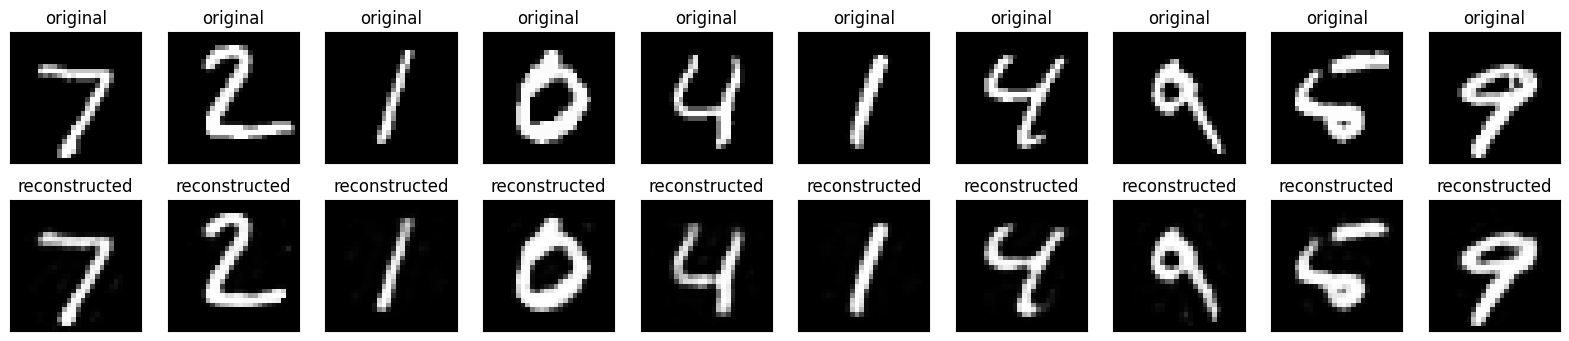

In [9]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


In [15]:
autoencoder.save("autoencoder_save", save_format="tf")


## Denoising images

In [10]:
from tensorflow.keras.datasets import fashion_mnist


In [16]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [17]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)


(60000, 28, 28, 1)


In [18]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

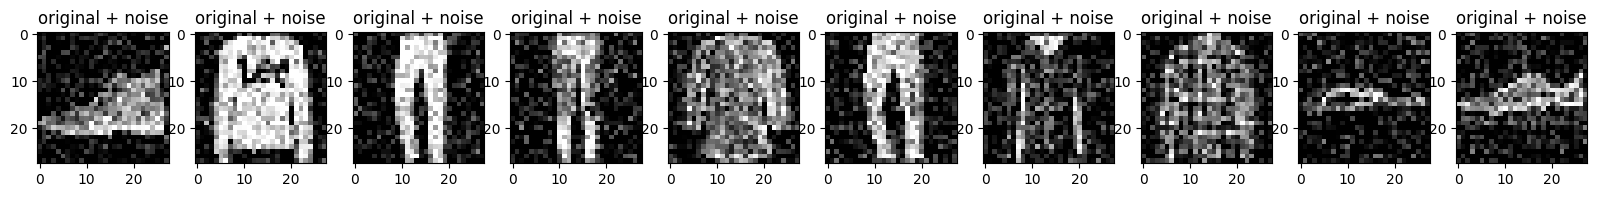

In [19]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [23]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [24]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [25]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                batch_size=1024,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
59/59 [==============================] - 7s 35ms/step - loss: 0.1299 - val_loss: 0.0396
Epoch 2/10
59/59 [==============================] - 1s 18ms/step - loss: 0.0268 - val_loss: 0.0209
Epoch 3/10
59/59 [==============================] - 1s 19ms/step - loss: 0.0184 - val_loss: 0.0168
Epoch 4/10
59/59 [==============================] - 1s 18ms/step - loss: 0.0158 - val_loss: 0.0151
Epoch 5/10
59/59 [==============================] - 1s 18ms/step - loss: 0.0144 - val_loss: 0.0140
Epoch 6/10
59/59 [==============================] - 1s 18ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 7/10
59/59 [==============================] - 1s 20ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 8/10
59/59 [==============================] - 1s 22ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 9/10
59/59 [==============================] - 1s 19ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 10/10
59/59 [==============================] - 1s 20ms/step - loss: 0.0112 - val_loss: 0.0111


In [26]:
autoencoder.encoder.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

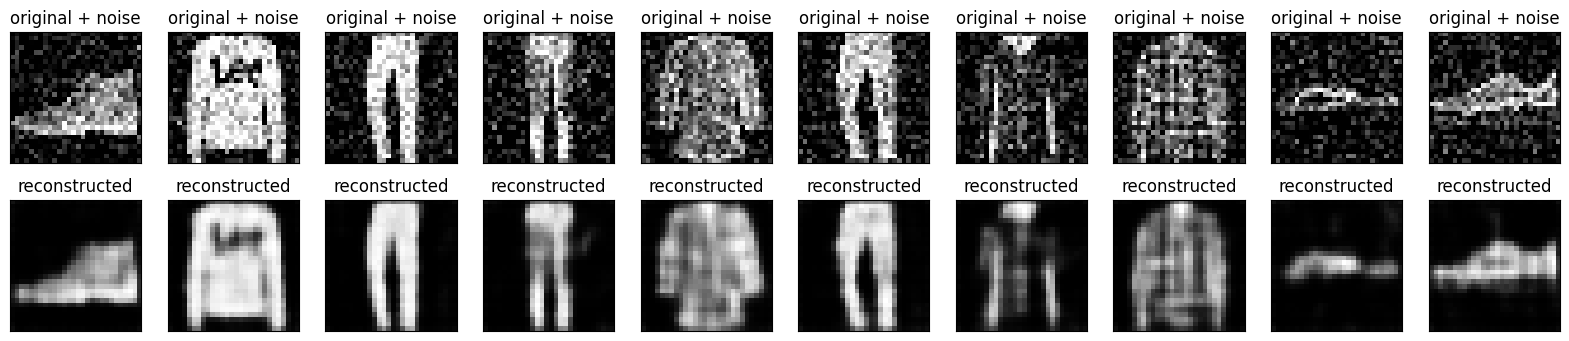

In [29]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()